# Moj rad

In [2]:
from __future__ import print_function
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD
from keras.models import model_from_json

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans

%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 8, 4 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

from pocetak import *
from services.preparation_for_neural_network import *
from services.show_result import *

In [3]:
# kreiranje recnika svih poznatih reci, za korekciju Levenstein rastojanjem
VOCABULARY_PATH = 'dataset/dict.txt'
vocabulary = dict()
with open(VOCABULARY_PATH, 'r', encoding='utf-8') as file:
    data = file.read()
    lines = data.split('\n')
    for index, line in enumerate(lines):
        cols = line.split()
        if len(cols) == 3:
            vocabulary[cols[1]] = cols[2]

Broj prepoznatih regiona: 30
Broj prepoznatih regiona: 30
duzina inputa: 60
duzina outputs: 60
Istrenirani model uspesno ucitan.


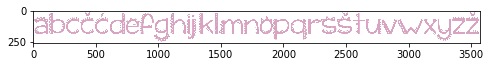

In [4]:
image_path0 = 'dataset/train/alphabet1.png'
letters0 = load_image_and_find_roi_train(image_path0)
alphabet0 = ['A', 'B', 'C', 'Č', 'Ć', 'D', 'E', 'F', 'G', 'H','I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S','Š', 'T', 'U','V', 'W', 'X', 'Y', 'Z', 'Ž']

image_path1 = 'dataset/train/alphabet1.png'
letters1 = load_image_and_find_roi_train(image_path1)
alphabet1 = ['a', 'b', 'c', 'č', 'ć', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q',
            'r', 's', 'š', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ž']
alphabet= alphabet0 + alphabet1
letters = letters0 + letters1

inputs = prepare_for_ann(letters)
outputs = convert_output(alphabet)
print("duzina inputa: " + str(len(inputs)))
print("duzina outputs: " + str(len(outputs)))

# probaj da ucitas prethodno istreniran model
ann = load_trained_ann()

# ako je ann=None, znaci da model nije ucitan u prethodnoj metodi i da je potrebno istrenirati novu mrezu
if ann is None:
    print("Traniranje modela zapoceto.")
    ann = create_ann()
    ann = train_ann(ann, inputs, outputs)
    print("Treniranje modela zavrseno.")
    # serijalizuj novu mrezu nakon treniranja, da se ne trenira ponovo svaki put
    serialize_ann(ann)

In [ ]:
# Učitavanje slike i određivanje regiona od interesa
validation_image_path = 'dataset/validation/train5.png'
distances, letters = load_image_and_find_roi_HSV_validate(validation_image_path)

In [ ]:
# PREDIKCIJA
print(extract_text(distances, letters, ann,vocabulary))

pronadjeno kontura: 82
meni koristnih: 31


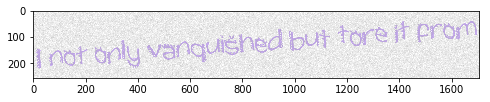

In [5]:
# POPRAVLJANJEEEE SEGMENTACIJE
image_path = 'dataset/validation/train20.png'

img = cv2.imread(image_path)
image = img.copy()
best_channel = image[:, :, 1]
ret, image_bin = cv2.threshold(best_channel, 0, 255, cv2.THRESH_OTSU)
invertovana = invert(image_bin)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opening = cv2.morphologyEx(invertovana, cv2.MORPH_OPEN, kernel, iterations=1)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
# closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)

imga, contours, hierarchy = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_crtanje = img.copy()
regions_array = []
print("pronadjeno kontura: " + str(len(contours)))
regija_kvacica = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    region = opening[y-20:y + h + 1, x:x + w + 1] # UBACITI NEKI HENDLER, tipa ako je y-20 <0 uraditi y - 10 tako nesto
    
    area = cv2.contourArea(contour)
    
    if w < 10 or h < 45 or (h + w) < 50:
        
#         print("\t\t\th: " + str(h) + " w: " + str(w) + " size: " + str(h + w))
        continue
#     cv2.rectangle(image_crtanje, (x, y), (x + w, y + h), (0, 255, 0), 4)
    #     print("h: " + str(h) + " w: " + str(w) + " size: " + str(h + w))
    # TODO: Uzmem region iznad h/2 jer da ne gledam celu velicinu H(visinu) jer sigurno nije toliko
    # pomerena kvacica
#     try:
#         region_iznad = opening[y - int(h/2):y + 1, x:x + w + 1]
#         _, kvacice_contours, _ = cv2.findContours(region_iznad.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         print("pronadjedno kontura iznad: " + str(len(kvacice_contours)))
#         ima_kvacice = False
#         for cnt in kvacice_contours:
#             x1, y1, w1, h1 = cv2.boundingRect(cnt)
#             print("h1: " + str(h1) + " w1: " + str(w1) + " size1: " + str(h1 + w1) + " h/2: " + str(int(h/2)))
# #             if h1 < 5 or w1 < 3: # preskacem male
# #                 print("preskacem male")
# #                 continue
# #             if h1 > 100 or w1 > 100: # preskacem velike
# #                 print("preskacem velike")
# #                 continue
#             # ostale su kvacice(pretpostavka)
#             ima_kvacice = True
#             break
#         if ima_kvacice:
#             print("\t\t\t\tima kvacice")
#             region=opening[y - int(h/2):y + h + 1, x:x + w + 1]
                
#         else:
#             print("\t\t\t\tnema kvacice")
        
#     except:
#         print("izuzetak")
    # TODO: Proverim da li u njemu ima 'koristne konture' tj kvacice
    # ako ima onda ta dva regiona spojim u jedan :
    
    
    # TODO: STAVITI RESIZE_REGION AKO HOCU DA RESIZUJEM
    regions_array.append([resize_region(region), (x, y, w, h)])
    
    
plt.imshow(image_crtanje)

# image_crtanje = img.copy()
# cv2.drawContours(image_crtanje, contours, -1, (255, 0, 0), 2)
# plt.imshow(image_crtanje)

regions_array = sorted(regions_array, key=lambda item: item[1][0])

sorted_regions = [region[0] for region in regions_array]
sorted_rectangles = [region[1] for region in regions_array]
    

region_distances = []
# Izdvojiti sortirane parametre opisujućih pravougaonika
# Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
for index in range(0, len(sorted_rectangles) - 1):    
    current = sorted_rectangles[index]
    next_rect = sorted_rectangles[index + 1]    
    distance = next_rect[0] - (current[0] + current[2])  # X_next - (X_current + W_current)
    region_distances.append(distance)

# plt.imshow(sorted_regions[0])
# display_image(image_crtanje)
# plt.imshow(image_crtanje)
print("meni koristnih: " + str(len(sorted_regions)))


In [6]:
# PREDIKCIJA
print(extract_text(region_distances, sorted_regions, ann,vocabulary))

		 recenica: l hbt bhty WdhqJibhGJ Eut tbdd it bhbd
		 procesirana recenica: All But by which But bad it behind

All But by which But bad it behind


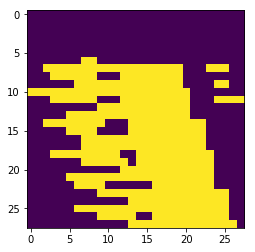

In [7]:
plt.imshow(sorted_regions[0])

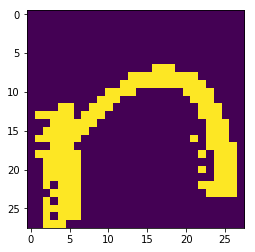

In [8]:
plt.imshow(sorted_regions[1])

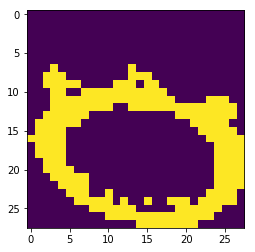

In [9]:
plt.imshow(sorted_regions[2])

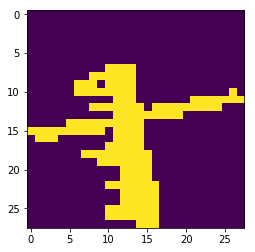

In [10]:
plt.imshow(sorted_regions[3])

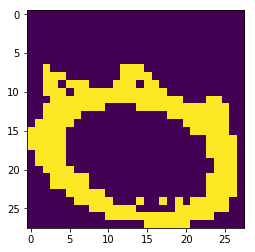

In [13]:
plt.imshow(sorted_regions[4])

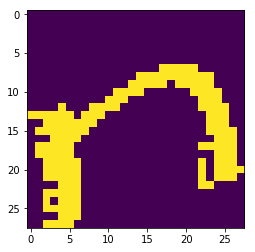

In [14]:
plt.imshow(sorted_regions[5])

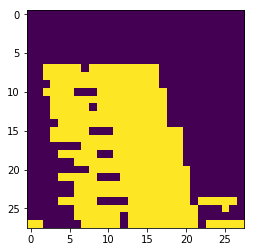

In [15]:
plt.imshow(sorted_regions[6])

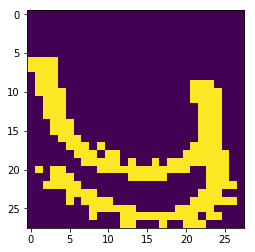

In [16]:
plt.imshow(sorted_regions[7])

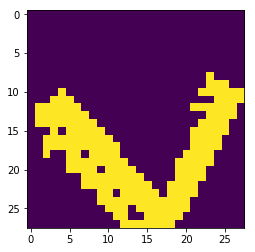

In [17]:
plt.imshow(sorted_regions[8])

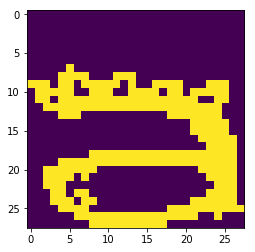

In [18]:
plt.imshow(sorted_regions[9])

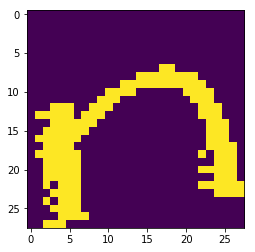

In [19]:
plt.imshow(sorted_regions[10])

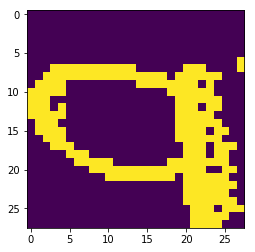

In [20]:
plt.imshow(sorted_regions[11])

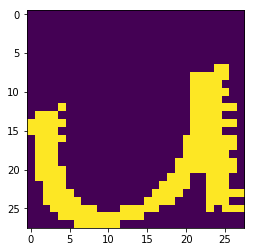

In [21]:
plt.imshow(sorted_regions[12])

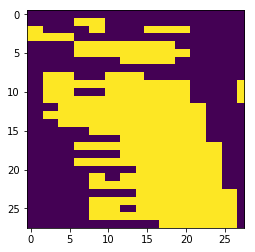

In [22]:
plt.imshow(sorted_regions[13])

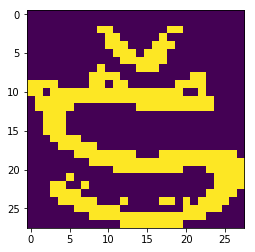

In [23]:
plt.imshow(sorted_regions[14])

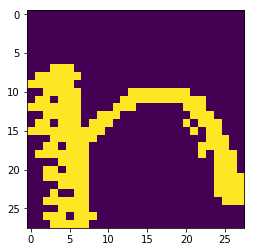

In [24]:
plt.imshow(sorted_regions[15])

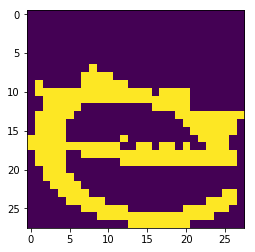

In [25]:
plt.imshow(sorted_regions[16])

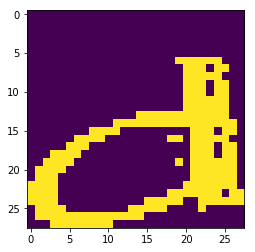

In [26]:
plt.imshow(sorted_regions[17])

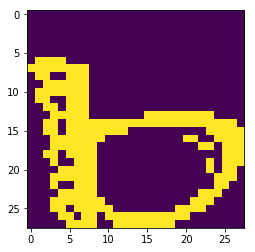

In [27]:
plt.imshow(sorted_regions[18])

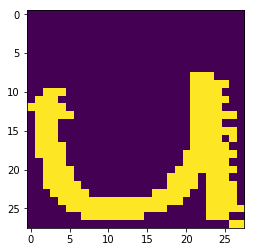

In [28]:
plt.imshow(sorted_regions[19])

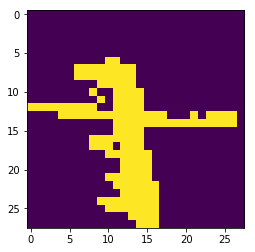

In [29]:
plt.imshow(sorted_regions[20])

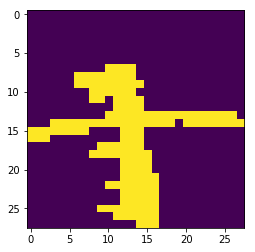

In [30]:
plt.imshow(sorted_regions[21])

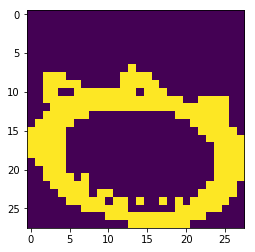

In [31]:
plt.imshow(sorted_regions[22])

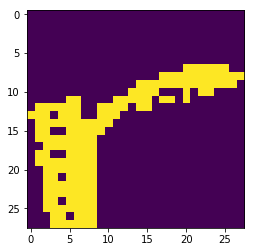

In [32]:
plt.imshow(sorted_regions[23])

In [ ]:
plt.imshow(sorted_regions[24])

In [ ]:
plt.imshow(sorted_regions[25])

In [ ]:
plt.imshow(sorted_regions[26])

In [ ]:
plt.imshow(sorted_regions[27])

In [ ]:
plt.imshow(sorted_regions[28])

In [ ]:
plt.imshow(sorted_regions[29])

In [ ]:
plt.imshow(sorted_regions[30])

In [ ]:
plt.imshow(sorted_regions[31])

In [ ]:
plt.imshow(sorted_regions[32])

In [ ]:
plt.imshow(sorted_regions[33])

In [ ]:
plt.imshow(sorted_regions[34])

In [ ]:
plt.imshow(sorted_regions[35])